# Unsupervised sentence embedding learning - GPL

In this notebook we will implement [GPL: Generative Pseudo Labeling for Unsupervised Domain Adaptation of Dense Retrieval](https://arxiv.org/abs/2112.07577) by `Kexin Wang, Nandan Thakur, Nils Reimers and Iryna Gurevych`.

Here is the summary of the paper by the authors.

> Dense retrieval approaches can overcome the lexical gap and lead to significantly improved search results. However, they require large amounts of training data which is not available for most domains. As shown in previous work (Thakur et al., 2021b), the performance of dense retrievers severely degrades under a domain shift. This limits the usage of dense retrieval approaches to only a few domains with large training datasets.
In this paper, we propose the novel unsupervised domain adaptation method Generative Pseudo Labeling (GPL), which combines a query generator with pseudo labeling from a cross-encoder. On six representative domain-specialized datasets, we find the proposed GPL can outperform an out-of-the-box state-of-the-art dense retrieval approach by up to 9.3 points nDCG@10. GPL requires less (unlabeled) data from the target domain and is more robust in its training than previous methods.
>
> We further investigate the role of six recent pre-training methods in the scenario of domain adaptation for retrieval tasks, where only three could yield improved results. The best approach, TSDAE (Wang et al., 2021) can be combined with GPL, yielding another average improvement of 1.4 points nDCG@10 across the six tasks. The code and the models are available at [this https URL](https://github.com/UKPLab/gpl).

GPL consists of the followings steps:
- Collecting passages from the target domain
- Query generation from the passages using a finetuned t5 model(`doc2query/msmarco-t5-base-v1`)
- Using a finetuned model(`msmarco-distilbert-base-tas-b`) for retrieval to retrieve top passages for each query
- Uing a finetuned Cross-Encoder(`cross-encoder/ms-marco-MiniLM-L-6-v2`) to mine hard negatives from the retrieved passages
- Training a Bi-Encoder using the (query, positive, hard negative, Cross-Encoder score) on MarginMSE loss

![](assets/gpl.png)

In short, we are generating queries, mining hard negatives and finetuning a Bi-Encoder to mimic the Cross-Encoder.
MarginMSE loss is perfect for such teacher-student model training.

$$ L(Q, P^{+}, P^{-}) = MSE(M_{s}(Q, P^{+}) - M_{s}(Q, P^{-}),  M_{t}(Q, P^{+}) - M_{t}(Q, P^{-}) )) $$

𝑃+ : Positive passage<br>
𝑃- : Negative passage<br>
𝑀𝑡 : Teacher model(Cross-Encoder)<br>
𝑀𝑠 : Student model(Bi-Encoder)


Hard negatives play a key role here. Hard negatives are passages that are related to the query but don't exactly answer the question but mention some other fact maybe. This depends a lot on the domain as there can't be universal sentence encoder.<br>
For example do we encode these two sentences closer in the vector space or farther? `Nuclear energy in safe!`, `Nuclear energy is dangerous`. The answer will depend on the domain, if we are focusing on nuclear energy then yes, if we are focusing on safety issues then maybe not.

| ![](assets/hard_negatives.png) | 
|:--:| 
| Effects of using hard negatives in retrieval systems. (Image source: https://arxiv.org/pdf/2010.08191.pdf)  |

GPL can be used both to finetune a pretrained model or as a domain adaptaion technique for a finetuned Bi-Encoder model. Here we will do the domain adaptation.

Ideally we would need lots in-domain data, here we will explore the core idea with a small dataset(due to the resourse constraints).

## Data preparation 

In [1]:
import pickle
import random
from tqdm import tqdm

import datasets
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import CrossEncoder, InputExample, losses, SentenceTransformer, util
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
dataset = datasets.load_dataset("BeIR/nfcorpus", "corpus", "corpus")

len(dataset["corpus"]), dataset["corpus"][0]

Using custom data configuration corpus-data_dir=corpus
Reusing dataset nfcorpus (/home/utsav/.cache/huggingface/datasets/BeIR___nfcorpus/corpus-data_dir=corpus/0.0.0/093f1fe2ffa7a9c72fa48239c8f279b51d6b171abd77737c7fd1406125307599)


  0%|          | 0/1 [00:00<?, ?it/s]

(3633,
 {'_id': 'MED-10',
  'title': 'Statin Use and Breast Cancer Survival: A Nationwide Cohort Study from Finland',
  'text': 'Recent studies have suggested that statins, an established drug group in the prevention of cardiovascular mortality, could delay or prevent breast cancer recurrence but the effect on disease-specific mortality remains unclear. We evaluated risk of breast cancer death among statin users in a population-based cohort of breast cancer patients. The study cohort included all newly diagnosed breast cancer patients in Finland during 1995–2003 (31,236 cases), identified from the Finnish Cancer Registry. Information on statin use before and after the diagnosis was obtained from a national prescription database. We used the Cox proportional hazards regression method to estimate mortality among statin users with statin use as time-dependent variable. A total of 4,151 participants had used statins. During the median follow-up of 3.25 years after the diagnosis (range 0.08

In [4]:
passages = []

for text in dataset["corpus"]:
    passages.append(text["text"])

len(passages)

3633

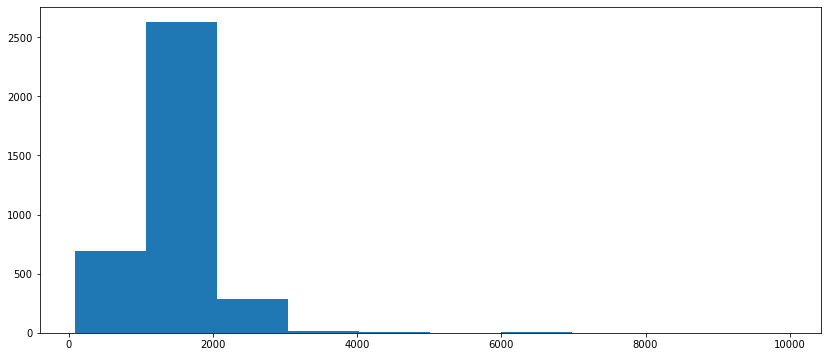

In [5]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.hist([len(passage) for passage in passages]);

## Query generation

In [6]:
def generate_questions(
    tokenizer: AutoTokenizer, model: AutoModelForSeq2SeqLM, passages: list[str],
    batch_size: int=32, device: str="cuda", n_ques_per_passage: int = 3
) -> list[str]:

    outputs = []
    n_batches = len(passages) // batch_size + int(len(passages) % batch_size != 0)

    for n in tqdm(range(n_batches)):
        passages_batch = passages[n*batch_size: (n+1)*batch_size]
        inputs = tokenizer(passages_batch, padding=True, truncation=True,
                           max_length=512, return_tensors="pt")
        output = model.generate(
            input_ids=inputs['input_ids'].to(device),
            attention_mask=inputs['attention_mask'].to(device),
            max_length=64,
            do_sample=True,
            top_p=0.9,
            num_return_sequences=n_ques_per_passage
        )
        outputs += output

    questions = [tokenizer.decode(txt, skip_special_tokens=True) for txt in outputs]
    return questions

In [7]:
model_name = "doc2query/msmarco-t5-base-v1"

doc2q_tokenizer = AutoTokenizer.from_pretrained(model_name)
doc2q_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

In [8]:
n_ques_per_passage = 3
questions = generate_questions(
    doc2q_tokenizer, doc2q_model, passages, n_ques_per_passage=n_ques_per_passage
)

100%|███████████████████████████████████████████████████████████████████████| 114/114 [01:41<00:00,  1.12it/s]


In [9]:
q2pix = {}  # query to passage index mapping

pix = 0
for i in range(len(questions)):
    if i > 0 and i % n_ques_per_passage == 0:
        pix += 1
    q2pix[questions[i]] = pix

Let's look at some passages and the generated questions ...

In [10]:
n = 0

for question, passage_ix in q2pix.items():
    print(passages[passage_ix])
    print(f"[Q] {question} ?\n---\n")
    n += 1
    if n == (n_ques_per_passage * 3):
        break

Recent studies have suggested that statins, an established drug group in the prevention of cardiovascular mortality, could delay or prevent breast cancer recurrence but the effect on disease-specific mortality remains unclear. We evaluated risk of breast cancer death among statin users in a population-based cohort of breast cancer patients. The study cohort included all newly diagnosed breast cancer patients in Finland during 1995–2003 (31,236 cases), identified from the Finnish Cancer Registry. Information on statin use before and after the diagnosis was obtained from a national prescription database. We used the Cox proportional hazards regression method to estimate mortality among statin users with statin use as time-dependent variable. A total of 4,151 participants had used statins. During the median follow-up of 3.25 years after the diagnosis (range 0.08–9.0 years) 6,011 participants died, of which 3,619 (60.2%) was due to breast cancer. After adjustment for age, tumor characteris

In [11]:
unique_questions = list(set(questions))
len(unique_questions)

10692

## Negative mining 

In [12]:
torch.cuda.empty_cache()

In [5]:
retriever = SentenceTransformer("msmarco-distilbert-base-tas-b", device="cuda")

In [6]:
passage_embeddings = retriever.encode(passages)

In [17]:
def get_topk_passages(
    model: SentenceTransformer, query: str, passage_embeds: torch.tensor, n: int=10
) -> tuple[np.array, list[float]]:
    query_embed = model.encode(query)
    sim_scores = util.cos_sim(query_embed, passage_embeds).numpy()
    top_passages_ix = np.argsort(sim_scores)[0][::-1][:n]
    return top_passages_ix, [sim_scores[0][ix] for ix in top_passages_ix]

In [16]:
query_passage_pairs = []

for query in tqdm(unique_questions):
    top_passages_ixs, _ = get_topk_passages(retriever, query, passage_embeddings, 3)
    query_passage_pairs += [(query, passages[ix]) for ix in top_passages_ixs if ix != q2pix[query]]

100%|██████████████████████████████████████████████████████████████████| 10692/10692 [01:10<00:00, 150.91it/s]


In [17]:
len(query_passage_pairs)

25082

Let's look at some query, positive and negative passages ...

In [18]:
for query, negative_passage in random.sample(query_passage_pairs, 3):
    print(f"[Q] {query}\n\n[NEGATIVE] {negative_passage}\n\n[POSITIVE] {passages[q2pix[query]]}\n---\n")

[Q] is rapamycin a fungi

[NEGATIVE] Proteins regulating the mammalian target of rapamycin (mTOR), as well as some of the targets of the mTOR kinase, are overexpressed or mutated in cancer. Rapamycin, the naturally occurring inhibitor of mTOR, along with a number of recently developed rapamycin analogs (rapalogs) consisting of synthetically derived compounds containing minor chemical modifications to the parent structure, inhibit the growth of cell lines derived from multiple tumor types in vitro, and tumor models in vivo. Results from clinical trials indicate that the rapalogs may be useful for the treatment of subsets of certain types of cancer. The sporadic responses from the initial clinical trials, based on the hypothesis of general translation inhibition of cancer cells are now beginning to be understood owing to a more complete understanding of the dynamics of mTOR regulation and the function of mTOR in the tumor microenvironment. This review will summarize the preclinical and c

In [19]:
ce = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', device="cuda")

In [20]:
query_passage_margins = []

for query, passage in tqdm(query_passage_pairs):
    p_score = ce.predict((query, passages[q2pix[query]]))
    n_score = ce.predict((query, passage))
    margin = p_score - n_score
    query_passage_margins.append((query, passages[q2pix[query]], passage, margin))

100%|██████████████████████████████████████████████████████████████████| 25082/25082 [03:26<00:00, 121.70it/s]


At this point, I save the data, restart the kernel to free up the GPU memory as I kept running into OOM.

> If you face the same issue, you'll need to 
> - load the libraries
> - load the the dataset
> - create the passages
> - load the retriever
> - redefine `get_topk_passages()`
> - create the passage embeddings we created using the retriever
>
> We will use the passage embeddings to compare the retrieval with the finetuned model.

In [29]:
with open("query_passage_margins.pkl", "wb") as f:
    pickle.dump(query_passage_margins, f)

#  restart kernel

In [7]:
with open("query_passage_margins.pkl", "rb") as f:
    query_passage_margins = pickle.load(f)

In [8]:
training_data = []
for query, passage_pos, passage_neg, margin in query_passage_margins:
    training_data.append(InputExample(texts=[query, passage_pos, passage_neg], label=float(margin)))

In [9]:
loader = torch.utils.data.DataLoader(training_data, batch_size=8, shuffle=True)

## Finetuning the Bi-Encoder 

In [10]:
torch.cuda.empty_cache()

In [11]:
bi_encoder = SentenceTransformer("msmarco-distilbert-base-tas-b", device="cuda")
bi_encoder.max_seq_length = 512

In [12]:
loss = losses.MarginMSELoss(bi_encoder)

In [13]:
bi_encoder.fit(
    train_objectives=[(loader, loss)],
    epochs=2,
    warmup_steps=int(len(loader)*0.1),
    show_progress_bar=True
)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3136 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3136 [00:00<?, ?it/s]

In [ ]:
new_passage_embeddings = bi_encoder.encode(passages)

For a proper evaluation, we will need some labeled data from our domain. Here I've cherry picked some examples to show how the in-domain fintetuned retriever is doing better than the geenral purpose finetuned Bi-Encoder we started with.

**Passage**<br>
BACKGROUND: Oral L-citrulline is efficiently converted to L-arginine, the precursor for endothelial nitric oxide (NO) synthesis. Oral L-arginine supplementation reduces brachial blood pressure (BP). We evaluated the effects of watermelon supplementation on aortic BP and arterial function in individuals with prehypertension. METHODS: Heart rate (HR), brachial systolic BP (bSBP), brachial pulse pressure (bPP), aortic SBP (aSBP), aortic PP (aPP), augmentation index (AIx), AIx adjusted for HR of 75 beats/min (AIx@75), amplitude of the first (P1) and second (P2) systolic peaks, reflection time (Tr), and carotid-femoral pulse wave velocity (PWV) were evaluated in the supine position in nine subjects (four men/five women, age 54 ± 3 years) with prehypertension (134/77 ± 5/3 mm Hg). Subjects were randomly assigned to 6 weeks of watermelon supplementation (L-citrulline/L arginine, 2.7 g/1.3 g/day) or placebo followed by a 4-week washout period and then crossover. RESULTS: There was a significant treatment effect (change in the value of watermelon minus placebo from baseline to 6 weeks) on bPP (-8 ± 3 mm Hg, P < 0.05), aSBP (-7 ± 2 mm Hg, P < 0.05), aPP (-6 ± 2 mm Hg, P < 0.01), AIx (-6 ± 3%, P < 0.05), AIx@75 (-4 ± 2%, P < 0.05), and P2 (-2 ± 1 mm Hg, P < 0.05). There was no significant treatment effect (P > 0.05) on bSBP, brachial diastolic BP (DBP), aortic DBP, Tr, P1, HR, and carotid-femoral PWV. CONCLUSIONS: This pilot study shows that watermelon supplementation improves aortic hemodynamics through a decrease in the amplitude of the reflected wave in individuals with prehypertension. 

In [48]:
query = "effects of watermelon supplementation"

top_passages_ixs, scores = get_topk_passages(bi_encoder, query, new_passage_embeddings, 5)
for ix, score in zip(top_passages_ixs, scores):
    print(score, passages[ix], "\n")

#  we got the correct passage at the third stop, also 2 out of the 5 retrieved documents
#  are focused on some fruit/vegetable supplementation

0.84084153 OBJECTIVE: Watermelon is a rich source of citrulline, an amino acid that can be metabolized to arginine, a conditionally essential amino acid for humans. Arginine is the nitrogenous substrate used in the synthesis of nitric oxide and plays an essential role in cardiovascular and immune functions. No detailed studies have been conducted to evaluate plasma arginine response in humans after long-term feeding of citrulline from natural plant sources. This study investigated if watermelon juice consumption increases fasting concentrations of plasma arginine, ornithine, and citrulline in healthy adult humans. METHODS: Subjects (n = 12-23/treatment) consumed a controlled diet and 0 (control), 780, or 1560 g of watermelon juice per day for 3 wk in a crossover design. The treatments provided 1 and 2 g of citrulline per day. Treatment periods were preceded by washout periods of 2 to 4 wk. RESULTS: Compared with the baseline, fasting plasma arginine concentrations increased 12% after 3

In [49]:
top_passages_ixs, scores = get_topk_passages(retriever, query, passage_embeddings, 5)
for ix, score in zip(top_passages_ixs, scores):
    print(score, passages[ix], "\n")

#  here we failed to get the correct passage and only 1 out of 5 retrieved passages
#  is talking about supplementaion

0.79298615 OBJECTIVE: Watermelon is a rich source of citrulline, an amino acid that can be metabolized to arginine, a conditionally essential amino acid for humans. Arginine is the nitrogenous substrate used in the synthesis of nitric oxide and plays an essential role in cardiovascular and immune functions. No detailed studies have been conducted to evaluate plasma arginine response in humans after long-term feeding of citrulline from natural plant sources. This study investigated if watermelon juice consumption increases fasting concentrations of plasma arginine, ornithine, and citrulline in healthy adult humans. METHODS: Subjects (n = 12-23/treatment) consumed a controlled diet and 0 (control), 780, or 1560 g of watermelon juice per day for 3 wk in a crossover design. The treatments provided 1 and 2 g of citrulline per day. Treatment periods were preceded by washout periods of 2 to 4 wk. RESULTS: Compared with the baseline, fasting plasma arginine concentrations increased 12% after 3

**Passage**<br>
The use of over-the-counter supplements is commonplace in today's health conscious society. We present an unusual case of intrahepatic cholestasis caused by vitamin A intoxication. The patient consumed one Herbalife shake with two multivitamin tablets of the same brand for 12 years. When calculated this equated to more than the recommended daily allowance for vitamin A consumption. Deranged liver function tests were consistent with a cholestatic process. Liver biopsy was obtained and revealed features pathognomonic of vitamin A toxicity, without the usual fibrosis. When the supplements were ceased, his jaundice and alkaline phosphatase completely normalized. This case highlights the importance of health care providers documenting non-prescribed dietary supplements and considering them in the etiology of cholestatic liver disease. Copyright 2009 Elsevier Inc. All rights reserved.

In [21]:
query = "what causes intrahepatic cholestasis"

top_passages_ixs, scores = get_topk_passages(bi_encoder, query, new_passage_embeddings, 3)
for ix, score in zip(top_passages_ixs, scores):
    print(score, passages[ix], "\n")

#  we got the correct passage at top with a high score

0.84828144 The use of over-the-counter supplements is commonplace in today's health conscious society. We present an unusual case of intrahepatic cholestasis caused by vitamin A intoxication. The patient consumed one Herbalife shake with two multivitamin tablets of the same brand for 12 years. When calculated this equated to more than the recommended daily allowance for vitamin A consumption. Deranged liver function tests were consistent with a cholestatic process. Liver biopsy was obtained and revealed features pathognomonic of vitamin A toxicity, without the usual fibrosis. When the supplements were ceased, his jaundice and alkaline phosphatase completely normalized. This case highlights the importance of health care providers documenting non-prescribed dietary supplements and considering them in the etiology of cholestatic liver disease. Copyright 2009 Elsevier Inc. All rights reserved. 

0.8270186 Our understanding of coronary artery disease risk and the atherosclerotic process has

In [51]:
top_passages_ixs, scores = get_topk_passages(retriever, query, passage_embeddings, 3)
for ix, score in zip(top_passages_ixs, scores):
    print(score, passages[ix], "\n")

#  we got the correct passage at the third place and the score distrubtion is pretty flat

0.79298615 OBJECTIVE: Watermelon is a rich source of citrulline, an amino acid that can be metabolized to arginine, a conditionally essential amino acid for humans. Arginine is the nitrogenous substrate used in the synthesis of nitric oxide and plays an essential role in cardiovascular and immune functions. No detailed studies have been conducted to evaluate plasma arginine response in humans after long-term feeding of citrulline from natural plant sources. This study investigated if watermelon juice consumption increases fasting concentrations of plasma arginine, ornithine, and citrulline in healthy adult humans. METHODS: Subjects (n = 12-23/treatment) consumed a controlled diet and 0 (control), 780, or 1560 g of watermelon juice per day for 3 wk in a crossover design. The treatments provided 1 and 2 g of citrulline per day. Treatment periods were preceded by washout periods of 2 to 4 wk. RESULTS: Compared with the baseline, fasting plasma arginine concentrations increased 12% after 3

**Passage**<br>
Epidemiologic studies suggest that dietary lutein and zeaxanthin may be of benefit in maintaining cognitive health. Among the carotenoids, lutein and zeaxanthin are the only two that cross the blood-retina barrier to form macular pigment (MP) in the eye. They also preferentially accumulate in the human brain. Lutein and zeaxanthin in macula from nonhuman primates were found to be significantly correlated with their concentrations in matched brain tissue. Therefore, MP can be used as a biomarker of lutein and zeaxanthin in primate brain tissue. This is of interest given that a significant correlation was found between MP density and global cognitive function in healthy older adults. An examination of a relation between cognition and lutein and zeaxanthin concentrations in the brain tissue of decedents from a population-based study in centenarians found that zeaxanthin concentrations in brain tissue were significantly related to antemortem measures of global cognitive function, memory retention, verbal fluency, and dementia severity after adjustment for age, sex, education, hypertension, and diabetes. In univariate analyses, lutein was related to recall and verbal fluency, but the strength of the associations was attenuated with adjustment for covariates. However, lutein concentrations in the brain were significantly lower in individuals with mild cognitive impairment than in those with normal cognitive function. Last, in a 4-mo, double-blinded, placebo-controlled trial in older women that involved lutein supplementation (12 mg/d), alone or in combination with DHA (800 mg/d), verbal fluency scores improved significantly in the DHA, lutein, and combined-treatment groups. Memory scores and rate of learning improved significantly in the combined-treatment group, who also showed a trend toward more efficient learning. When all of these observations are taken into consideration, the idea that lutein and zeaxanthin can influence cognitive function in older adults warrants further study.

In [52]:
query = "benefits of zeaxanthin"

top_passages_ixs, scores = get_topk_passages(bi_encoder, query, new_passage_embeddings, 3)
for ix, score in zip(top_passages_ixs, scores):
    print(score, passages[ix], "\n")

#  we got the correct passage at top and the third passage also looks like a correct answer

0.83842903 Epidemiologic studies suggest that dietary lutein and zeaxanthin may be of benefit in maintaining cognitive health. Among the carotenoids, lutein and zeaxanthin are the only two that cross the blood-retina barrier to form macular pigment (MP) in the eye. They also preferentially accumulate in the human brain. Lutein and zeaxanthin in macula from nonhuman primates were found to be significantly correlated with their concentrations in matched brain tissue. Therefore, MP can be used as a biomarker of lutein and zeaxanthin in primate brain tissue. This is of interest given that a significant correlation was found between MP density and global cognitive function in healthy older adults. An examination of a relation between cognition and lutein and zeaxanthin concentrations in the brain tissue of decedents from a population-based study in centenarians found that zeaxanthin concentrations in brain tissue were significantly related to antemortem measures of global cognitive function

In [46]:
top_passages_ixs, scores = get_topk_passages(retriever, query, passage_embeddings, 3)
for ix, score in zip(top_passages_ixs, scores):
    print(score, passages[ix], "\n")

#  we get the correct passage at the third place and missed the other answer

0.8006925 Presence of omega-3, omega-6 rich oil, alpha-linoleic acid, dietary fibers, secoisolariciresinol diglucoside, protein and minerals in flaxseed constitute a very strong basis for the utilization of flaxseed in various food preparations as a curative agent. An extensive body of literature illustrates that flaxseed has gained a significant position in the domain of nutritional sciences owing to its pivotal role as an antioxidant agent. The review discusses at length, numerous health benefits of flaxseed typically focusing its preventive role against cardiovascular diseases, cancer, diabetes and enhancement of spatial memory. Massive increase in the size of population with a special emphasize to the developing countries, there is an urge for exploration of the alternative dietary resources that can meet the dietary and nutritional needs of forthcoming generations. With respect to its remarkable nutritional importance, the review in question enables researchers engaged in nutritio

** When trying out other examples, remeber to focus on questions where the answer can be found at the beginning of the passage as we had a tokenization limit of 512.

---

## References

[1] Kexin Wang, Nandan Thakur, Nils Reimers and Iryna Gurevych. "[GPL: Generative Pseudo Labeling for Unsupervised Domain Adaptation of Dense Retrieval](https://arxiv.org/abs/2112.07577)"

[2] https://github.com/UKPLab/gpl

[3] Yingqi Qu, Yuchen Ding, Jing Liu, Kai Liu, Ruiyang Ren, Wayne Xin Zhao, Daxiang Dong, Hua Wu and Haifeng Wang. "[RocketQA: An Optimized Training Approach to Dense Passage Retrieval
for Open-Domain Question Answering](https://arxiv.org/pdf/2010.08191.pdf)"